In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os

## Keras
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Lambda, Conv2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.utils import multi_gpu_model
import keras.backend.tensorflow_backend as tfback
import tensorflow as tf

import cv2
import pandas as pd
import random
import ntpath

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [3]:
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

In [4]:
columns = ["img","steering"]
data = pd.read_csv(r'/home/u43783/driving_dataset/data.txt', sep = " ", names = columns)
datadir = '/home/u43783/driving_dataset'

In [5]:
def load_img_steering(datadir, df):
  """Get img and steering data into arrays"""
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center = indexed_data[0]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[1]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir , data)

In [6]:
X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=0)

In [7]:
def img_preprocess(img):
  """Take in path of img, returns preprocessed image"""
  img = npimg.imread(img)
  # Cropping the image
  img = img[60:-25, :, :]
  # Resizing the image
  img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
  # Converting the image to YUV
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    
  return img

In [8]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

In [9]:
def nvidia_model():
  model = Sequential()
  model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
  model.add(Conv2D(24, 5, 5, activation='relu', subsample=(2, 2)))
  model.add(Conv2D(36, 5, 5, activation='relu', subsample=(2, 2)))
  model.add(Conv2D(48, 5, 5, activation='relu', subsample=(2, 2)))
  model.add(Conv2D(64, 3, 3, activation='relu'))
  model.add(Conv2D(64, 3, 3, activation='relu'))
  model.add(Conv2D(16, 1, 1, activation='relu'))
  #model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1))
  # model.summary()
  optimizer = Adam(lr=1e-4)
  #model = multi_gpu_model(model, gpus = 2)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mean_squared_error'])
  # model.compile(loss='mse', optimizer=optimizer, metrics=['mean_squared_error'])
  return model

In [10]:
model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 18, 16)        

/opt/intel/inteloneapi/intelpython/latest/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
  after removing the cwd from sys.path.
/opt/intel/inteloneapi/intelpython/latest/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  """
/opt/intel/inteloneapi/intelpython/latest/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  
/opt/intel/inteloneapi/intelpython/latest/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  import sys
/opt/intel/inteloneapi/intelpython/latest/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update

In [11]:
filepath="my_cnn_1e4_16.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history = model.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid), batch_size=128, verbose=1, shuffle=1, callbacks=callbacks_list)
# model.save("my_cnn_1e4_16.h5")
# print("model saved")

Train on 36324 samples, validate on 9082 samples
Epoch 1/100
36324/36324 [==============================] - 61s 2ms/step - loss: 875.1198 - mean_squared_error: 875.1197 - val_loss: 875.8121 - val_mean_squared_error: 875.8121

Epoch 00001: val_loss improved from inf to 875.81214, saving model to my_cnn_1e4_16.hdf5
Epoch 2/100
36324/36324 [==============================] - 59s 2ms/step - loss: 743.0651 - mean_squared_error: 743.0653 - val_loss: 755.2208 - val_mean_squared_error: 755.2209

Epoch 00002: val_loss improved from 875.81214 to 755.22081, saving model to my_cnn_1e4_16.hdf5
Epoch 3/100
36324/36324 [==============================] - 59s 2ms/step - loss: 660.7605 - mean_squared_error: 660.7604 - val_loss: 683.8172 - val_mean_squared_error: 683.8172

Epoch 00003: val_loss improved from 755.22081 to 683.81720, saving model to my_cnn_1e4_16.hdf5
Epoch 4/100
36324/36324 [==============================] - 58s 2ms/step - loss: 587.8265 - mean_squared_error: 587.8265 - val_loss: 595.3651 

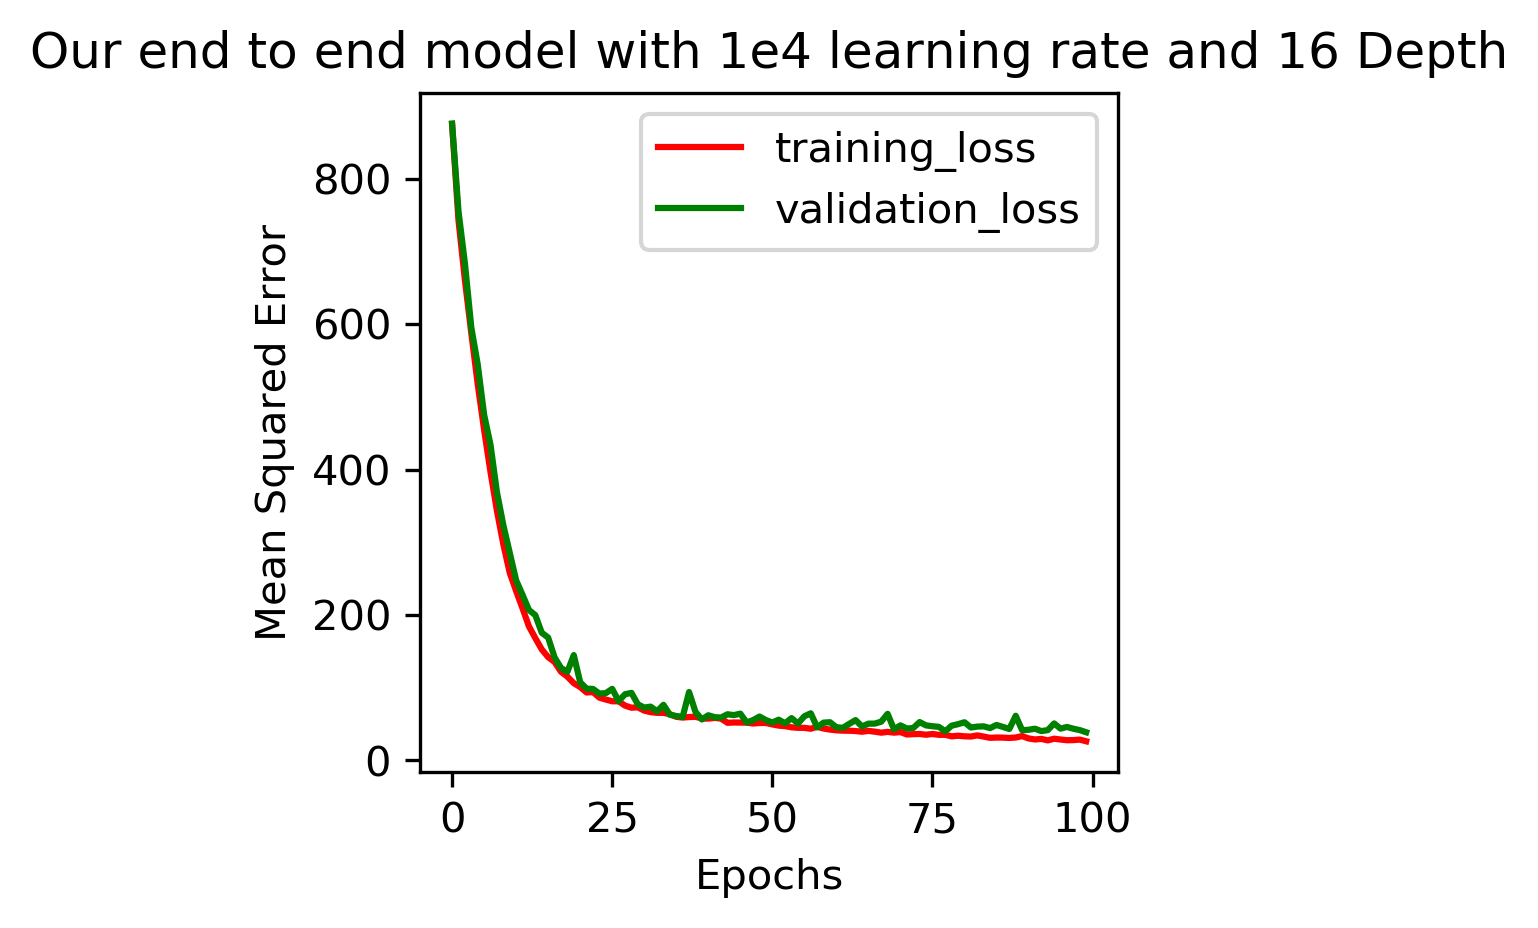

In [12]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(3, 3), dpi=300, facecolor='w', edgecolor='k')

plt.plot(history.history['loss'], color = 'red')
plt.plot(history.history['val_loss'], color = 'green')
plt.title('Our end to end model with 1e4 learning rate and 16 Depth')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.legend(['training_loss', 'validation_loss'], loc='upper right')
plt.savefig('MYMODEL_END_TO_END_1E4_16.png', dpi=300, bbox_inches='tight')
plt.show()